# USA President's speeches NLP

In this project we will deal with USA President's speeches using Natural Language Processing techniques. Our target is to implement sentiment analysis, extract information from text, model topics covered in speeches and generate short summaries of each speech.

In [37]:
import glob
import json
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import pprint
import random
import re
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.luhn import LuhnSummarizer

## First look

Let's take a look how our data is organized.

In [38]:
files = glob.glob("Trump/*.txt", recursive=True)
files

['Trump/FayettevilleSep9_2019.txt',
 'Trump/TupeloNov1_2019.txt',
 'Trump/NewHampshireAug15_2019.txt',
 'Trump/HendersonSep13_2020.txt',
 'Trump/OhioSep21_2020.txt',
 'Trump/PhoenixFeb19_2020.txt',
 'Trump/BattleCreekDec19_2019.txt',
 'Trump/PittsburghSep22_2020.txt',
 'Trump/ColoradorSpringsFeb20_2020.txt',
 'Trump/LatrobeSep3_2020.txt',
 'Trump/DallasOct17_2019.txt',
 'Trump/DesMoinesJan30_2020.txt',
 'Trump/MinneapolisOct10_2019.txt',
 'Trump/YumaAug18_2020.txt',
 'Trump/ToledoJan9_2020.txt',
 'Trump/CharlotteMar2_2020.txt',
 'Trump/Winston-SalemSep8_2020.txt',
 'Trump/TulsaJun20_2020.txt',
 'Trump/NewMexicoSep16_2019.txt',
 'Trump/HersheyDec10_2019.txt',
 'Trump/NewHampshireFeb10_2020.txt',
 'Trump/LasVegasFeb21_2020.txt',
 'Trump/NewHampshireAug28_2020.txt',
 'Trump/MindenSep12_2020.txt',
 'Trump/FreelandSep10_2020.txt',
 'Trump/CharlestonFeb28_2020.txt',
 'Trump/MosineeSep17_2020.txt',
 'Trump/MilwaukeeJan14_2020.txt',
 'Trump/LexingtonNov4_2019.txt',
 'Trump/BemidjiSep18_2020.tx

Let's see how a part of randomly chosen speech look like.

In [39]:
speech = open(files[random.randint(0,33)], "r")
print(speech.read()[:3000])

Hello, Manchester, and I am thrilled to be in the great state of New Hampshire with thousands of hardworking patriots who believe in God, family, and country. Thank you. Thank you. And I'll tell you what — we have more in this arena, and I hate to say this to you… we have more than this outside of the arena trying to get in. So if you'd like to give up your seat or where you're standing… Sorry we couldn't get you seats, but if you want to give it up, let them come in, you go out. Does anybody want to make that deal? I don't think so. But we have more in this arena and outside of this arena than all of the other candidates, meaning the Democrats, put together and multiplied times fave. And the fake news, these guys will never report that. They'll never report it. They don't even like showing the crowd. They always show my face. They never show the crowd. But you know what? The people can hear the crowd. The people can hear the crowd. They know. That is not the sound of 200 people. One o

## Data extraction

Each speech is located in a individual txt file named as follows : "town_month_day_year.txt". Let's extract this informations, number of words, sentences and text of speech into columns in one dataframe.

In [40]:
df = pd.DataFrame(columns=["City", "Month", "Day", "Year", "Words", "Sentences", "Speech"])

In [41]:
for file in files:
    x = re.search("/\w+-?\w+[A-Z]{1}", file)
    city = x.group()[1:-1]
    y = re.search("[A-Z][a-z]{2}\d+_", file)
    month = y.group()[0:3]
    z = re.search("\d{1}_\d", file)
    day = int(z.group()[0])
    t = re.search("_\d+", file)
    year = int(t.group()[1:])
    speech = open(file, "r").read()
    words = len(speech.split(" "))
    sentences = len(re.findall('\. ',speech))
    df = pd.concat([df, pd.DataFrame({"City":city, "Month":month, "Day":day, "Year": year, "Words": words, "Sentences": sentences, "Speech":speech}, index=[0])], ignore_index=True)

In [42]:
df.head()

,City,Month,Day,Year,Words,Sentences,Speech
0,Fayetteville,Sep,9,2019,9200,655,Thank you everybody. Thank you and Vice Presi...
1,Tupelo,Nov,1,2019,9271,809,"ell, thank you very much. And hello, Tupelo. T..."
2,NewHampshire,Aug,5,2019,10142,935,Thank you very much everybody. Thank you. Wow...
3,Henderson,Sep,3,2020,8930,794,"Thank you, thank you. Wow. Wow, and I'm thrill..."
4,Ohio,Sep,1,2020,10798,1025,"Wow, that's a big crowd. This is a big crowd. ..."


It's time for some statistics.

In [43]:
df.City.value_counts()

NewHampshire        3
Fayetteville        2
Winston-Salem       1
Wildwood            1
Cincinnati          1
Bemidji             1
Lexington           1
Milwaukee           1
Mosinee             1
Charleston          1
Freeland            1
Minden              1
LasVegas            1
Hershey             1
NewMexico           1
Tulsa               1
Charlotte           1
Tupelo              1
Toledo              1
Yuma                1
Minneapolis         1
DesMoines           1
Dallas              1
Latrobe             1
ColoradorSprings    1
Pittsburgh          1
BattleCreek         1
Phoenix             1
Ohio                1
Henderson           1
Greenville          1
Name: City, dtype: int64

President has visited most of places only once. Only exceptions are New Hampshire (3 times) and Fayetteville (2 times).

In [44]:
df.Year.value_counts()

2020    23
2019    11
Name: Year, dtype: int64

More president's speeches took place in 2020.

In [45]:
print("Average number of words in speeches from 2019: {}".format(df[df.Year == 2019]["Words"].mean()))

Average number of words in speeches from 2019: 10696.0


In [46]:
print("Average number of words in speeches from 2020: {}".format(df[df.Year == 2020]["Words"].mean()))

Average number of words in speeches from 2020: 10885.695652173914


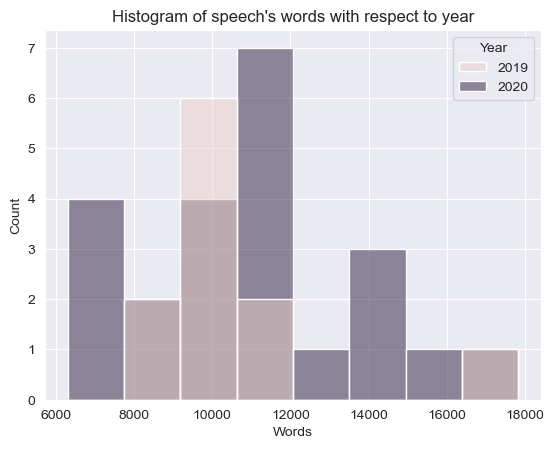

In [47]:
sns.histplot(df, x = "Words",  hue = "Year")
plt.title("Histogram of speech's words with respect to year")
plt.show()

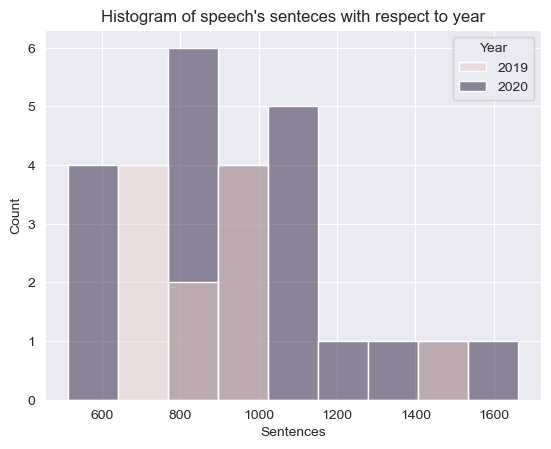

In [48]:
sns.histplot(df, x = "Sentences",  hue = "Year")
plt.title("Histogram of speech's senteces with respect to year")
plt.show()

## Text Preprocessing

In this part we will prepare our txt files into further analysis using methods like stop words removing, POS taging, normalization, tokenization and lemmatization.

In [49]:
stop_words = set(stopwords.words('english'))
normalizer = WordNetLemmatizer()

In [50]:
def get_part_of_speech(word):
    probable_part_of_speech = wordnet.synsets(word)
    pos_counts = Counter()
    pos_counts["n"] = len([ item for item in probable_part_of_speech if item.pos()=="n"])
    pos_counts["v"] = len([ item for item in probable_part_of_speech if item.pos()=="v"])
    pos_counts["a"] = len([ item for item in probable_part_of_speech if item.pos()=="a"])
    pos_counts["r"] = len([ item for item in probable_part_of_speech if item.pos()=="r"])
    most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
    return most_likely_part_of_speech

def preprocess_text(text):
    cleaned = re.sub(r'\W+', ' ', text).lower()
    tokenized = word_tokenize(cleaned)
    tokenized = [word for word in tokenized if word not in stop_words]
    normalized = " ".join([normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if not re.match(r'\d+',token)])
    return normalized

In [51]:
speeches_preprocessed = []
for speech in df.Speech:
    speeches_preprocessed.append(preprocess_text(speech))

## Wordclouds

Wordcloud is a cloud filled with lots of words in different sizes, which represent the frequency or the importance of each word. Let's implement this method using our speeches and plot all graphics at once.

In [52]:
wordcloud = WordCloud(background_color="white", max_words=50, contour_width=3, contour_color='steelblue')
images = []
for speech in speeches_preprocessed:
    wordcloud.generate(speech)
    images.append(wordcloud.to_image())

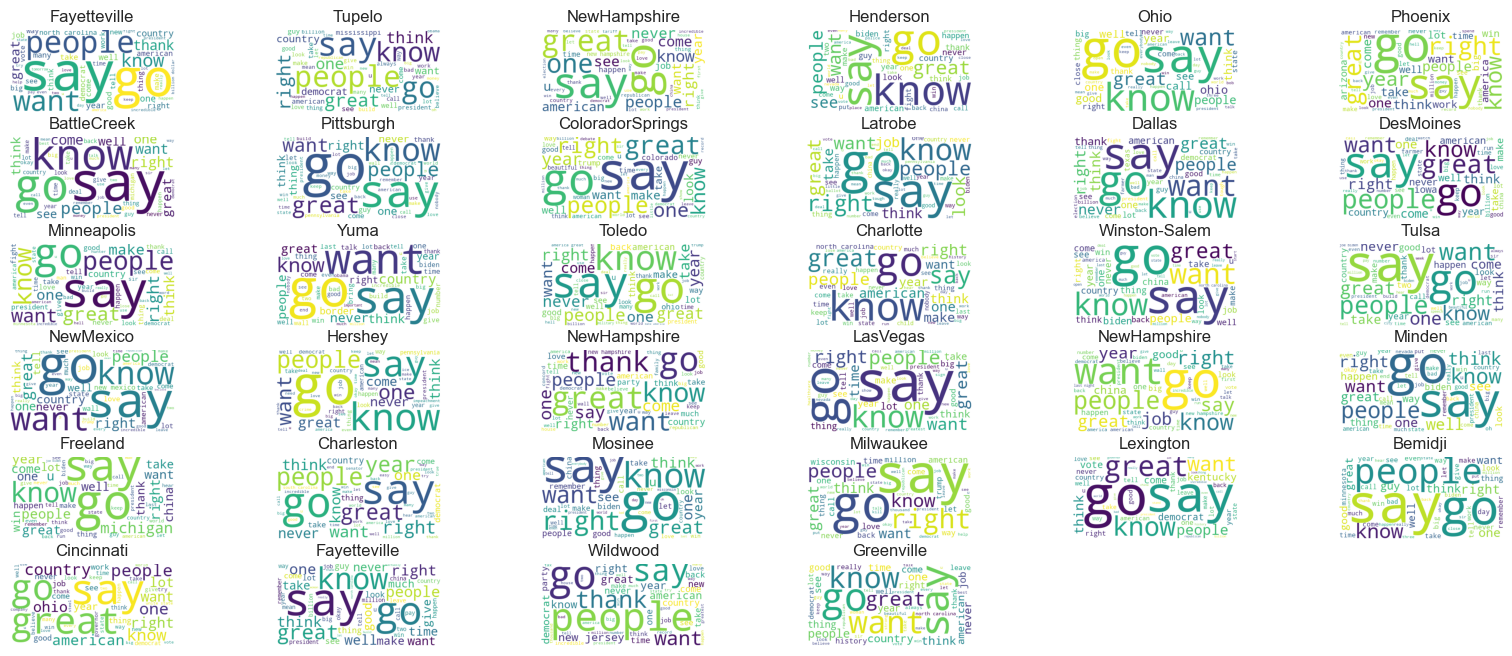

In [53]:
fig = plt.figure(figsize=(20, 8))
for i in range(34):
    fig.add_subplot(6, 6, i+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(images[i])
    plt.title(df.City[i])
    plt.axis("off")

## Sentiment Analysis

In this part we will calculate speech's probability of belonging to each of the 3 classes: negative, neutral and positive based on specific words occurrence and their frequency. In the end we will add this informations to our dataframe.

In [54]:
sid = SentimentIntensityAnalyzer()

neg, neu, pos = [], [], []

for speech in speeches_preprocessed:
    sentiment_dict = sid.polarity_scores(speech)
    neg.append(sentiment_dict["neg"])
    neu.append(sentiment_dict["neu"])
    pos.append(sentiment_dict["pos"])
    
df["Negative"] = neg
df["Neutral"] = neu
df["Positive"] = pos

In [55]:
df

,City,Month,Day,Year,Words,Sentences,Speech,Negative,Neutral,Positive
0,Fayetteville,Sep,9,2019,9200,655,Thank you everybody. Thank you and Vice Presi...,0.104,0.604,0.293
1,Tupelo,Nov,1,2019,9271,809,"ell, thank you very much. And hello, Tupelo. T...",0.157,0.590,0.253
2,NewHampshire,Aug,5,2019,10142,935,Thank you very much everybody. Thank you. Wow...,0.119,0.592,0.289
3,Henderson,Sep,3,2020,8930,794,"Thank you, thank you. Wow. Wow, and I'm thrill...",0.146,0.572,0.282
4,Ohio,Sep,1,2020,10798,1025,"Wow, that's a big crowd. This is a big crowd. ...",0.130,0.594,0.277
5,Phoenix,Feb,9,2020,9519,940,"Thank you very much, Phoenix. We love to be b...",0.167,0.564,0.268
6,BattleCreek,Dec,9,2019,17832,1460,Thank you. Thank you. Thank you to Vice Presid...,0.134,0.611,0.255
7,Pittsburgh,Sep,2,2020,12049,1090,Doesn't have the power. Doesn't have the stayi...,0.143,0.588,0.269
8,ColoradorSprings,Feb,0,2020,11655,1028,"Hello Colorado. We love Colorado, most beautif...",0.118,0.601,0.281
9,Latrobe,Sep,3,2020,12447,1038,"So thank you Pennsylvania, very much. I'm thri...",0.138,0.621,0.241


As you can see most speeches has been classified as neutral in terms of sentiment.

## Information Extraction (NER)

It's time for something even more interesting. Let's extract informations like mentioned persons, locations, organizations, date or events without reading text. The technique is called Named Entity Recognition.

In [56]:
nlp = spacy.load("en_core_web_lg")

In [57]:
ners = []
for i, speech in enumerate(speeches_preprocessed):
    dictionary = {}
    doc = nlp(speech)
    for ent in doc.ents:
        if ent.text:
            if ent.label_ not in dictionary.keys():
                dictionary[ent.label_] = []
            if ent.text not in dictionary[ent.label_]:
                dictionary[ent.label_].append(ent.text)
    
    ners.append(dictionary)
    filename = "NERS/" + files[i][6:-4] + "_NER.txt"
    with open(filename, "w") as ner_file:
        ner_file.write(json.dumps(dictionary))

Because output for each speech is really long we saved them into separate files in NERS folder. Check them out. Below we will print one of them.

In [58]:
for key, value in ners[-1].items():
    print(key, "\n", value)

GPE 
 ['greenville', 'north carolina', 'america', 'florida', 'south carolina', 'pennsylvania', 'wisconsin', 'michigan', 'china', 'minnesota', 'venezuela', 'israel', 'mexico', 'pocahontas', 'russia', 'ohio', 'california', 'los angeles', 'san francisco', 'nancy', 'virginia', 'charlotte', 'new york', 'iran', 'jerusalem', 'syria', 'iraq', 'germany']
PERSON 
 ['mike penny', 'mike night', 'clinton', 'donald trump', 'ilhan omar', 'greg stanton', 'omar', 'rashida tlaib', 'alexandria ocasio cortez', 'joe', 'harris', 'buttigieg buttigieg', 'buut ih jij', 'mike', 'ih jij buttigieg', 'xi china', 'kim jong un', 'vladimir putin', 'biden', 'ayanna pressle', 'dan forest', 'pj connelly', 'michael whatley', 'jim jordan', 'dr greg murphy greg', 'greg', 'greg elect', 'dan mccready', 'dan bishop dan', 'dan', 'bernie sander', 'bernie', 'royce', 'royce bernie', 'eric trump', 'brad parscale', 'dan scavino', 'joyce', 'donald', 'richard', 'gorsuch brett kavanaugh', 'arnold schwarzenegger', 'israel golan', 'obam

## Topic Modeling

Next we will identity what topics are discussed in president's speeches. This technique is called topic modelling and uses Latent Dirichlet Allocation. We will extract 8 different 8 word long topics.

In [59]:
vectorizer = TfidfVectorizer()
vectorizer_text = vectorizer.fit_transform(speeches_preprocessed)
vocab = vectorizer.get_feature_names_out()

lda_model = LatentDirichletAllocation(n_components=8, learning_method='online')
lda_top = lda_model.fit_transform(vectorizer_text)
topic_words = lda_model.components_

n_top_words = 8

topic_dict = {}

for i, topic_dist in enumerate(topic_words):
    sorted_topic_dist = np.argsort(topic_dist)
    topic_words = np.array(vocab)[sorted_topic_dist]
    topic_words = topic_words[:-n_top_words: -1]
    topic_dict["Topic " + str(i+1)] = topic_words

pd.Series(topic_dict)

Topic 1    [territory, meaner, uphill, foreigner, congres...
Topic 2    [vaccine, survive, regain, breath, obhof, duff...
Topic 3           [mate, reel, know, hater, go, toilet, get]
Topic 4    [sponsor, see, floodgate, airway, cast, com, k...
Topic 5    [hardworking, mitch, endanger, lobbyist, oath,...
Topic 6            [go, say, get, know, people, great, want]
Topic 7    [buyer, mansion, bondi, hydraulic, joint, pace...
Topic 8    [tim, tap, dossier, harvard, afraid, shop, duffy]
dtype: object

## Text Similarity

Thanks to converting text from each speech into vectors we have an opportunity to compare how similar in terms of distance between vectors are each two speeches. If you want to look how the result matrix look simply unhash last 3 lines (matrix is big and hard to read).

In [60]:
pairwise_similarity = vectorizer_text * vectorizer_text.T
similarity_matrix = pairwise_similarity.toarray()
# plt.figure(figsize=(16,10))
# sns.heatmap(similarity_matrix, annot=True)
# plt.show()

Let's select documents similar on level 0.85 or higher and save them into one table. Since the size of the matrix isn't small to speed up the process we will use some loops.

In [61]:
high_similarity_dict = {}
indexes = []

for i in range(34):
    for j in range(34):
        if similarity_matrix[i][j] > 0.85 and round(similarity_matrix[i][j],1) != 1:
            if ([i,j] not in indexes) and ([j,i] not in indexes):
                indexes.append([i,j])

for index in indexes:
    file_one = files[index[0]]
    name_one = file_one[6:-4]
    file_two = files[index[1]]
    name_two = file_two[6:-4]
    key = name_one + "_X_" + name_two
    high_similarity_dict[key] = similarity_matrix[index[0], index[1]]

pd.Series(high_similarity_dict)

BattleCreekDec19_2019_X_ToledoJan9_2020           0.852469
BattleCreekDec19_2019_X_LasVegasFeb21_2020        0.851790
BattleCreekDec19_2019_X_FayettevilleSep19_2020    0.866963
PittsburghSep22_2020_X_MosineeSep17_2020          0.857405
Winston-SalemSep8_2020_X_MindenSep12_2020         0.858604
Winston-SalemSep8_2020_X_MosineeSep17_2020        0.869553
MindenSep12_2020_X_MosineeSep17_2020              0.854181
MosineeSep17_2020_X_FayettevilleSep19_2020        0.865831
BemidjiSep18_2020_X_FayettevilleSep19_2020        0.858285
dtype: float64

First row represent names of two files, second row similarity level on scale [0-1]. This method found 9 pairs of very similar speeches.

## Text summary

As the name suggests at the very end we will generate a short 5 sentence long summary of each speech and add them into dataframe. To complete this we will use LuhnSummarizer. 

In [62]:
summaries = []
for speech in df.Speech:
    parser = PlaintextParser.from_string(speech, Tokenizer("english"))
    summarizer = LuhnSummarizer()
    summary = summarizer(parser.document, 5)
    summaries.append(summary)
    
df["Summary"] = summaries

Let's see one of them.

In [64]:
df.Summary[0]

(<Sentence: We've now had 13 straight months of wage gains of at least 3%, so the people that work so hard… You remember I used to say during the rallies before we won, people worked two jobs, three jobs and they made less money then they made 21 years before and now wages are going up, the economy is doing great and jobs have never been better.>,
 <Sentence: It was $12 billion and it was $16 billion, and out of the tariffs that we've taken in, we gave to our farmers for distribution, hopefully very good distribution, hopefully very even distribution, we've given them $28 billion so that they're whole.>,
 <Sentence: They're going to be coming to the United States in two or three weeks, and we'll see what happens, but unless we're going to make a good deal or a fair deal for our country, let's face it, we can not go back to a situation.>,
 <Sentence: I was even willing to stand out in the rain and get my hair soaking wet, but they said it was a little bit out of your district, and I sai

## Summary

Natural Language Processing methods allows us to extract a lot of important informations from text. Some of the presented methods are used by big companies like Google or Meta to analyze their customers' behaviour. Of course there are also other techniques like chatbots or text generation available to solve specific problems. I hope this project made you interested in NLP. Fell free to dive into big world of their applications.